# Introduction to Aquila

In the previous notebook, we have introduced the concept of Analog Hamiltonian Simulation (AHS) and how to run an AHS program on a Rydberg-based local simulator. In this notebook, we will illustrate how to run an AHS program on QuEra's Aquila, a Rydberg based QPU, via Amazon Braket. 



## Running an AHS program on Rydberg-based QPU

We have seen the basic components of an AHS program in the previous example, including the register, the driving and shifting fields. In order to run an AHS program on Aquila, however, these components have to meet certain requirements. Particularly, the first version of Aquila will not support shifting field. In this section, we will introduce other constraints via building up a valid program for Aquila step by step. 

### Register

Aquila can support up to 100 atoms... [say sth about the number of atoms]. 

1. The rows of the setup has to be separated by 
2. The atom has to be separated by 
3. The atom coordinates have to have maximum resolution 
4. The registers have to be within a bounding box of sizes
5. more?

In [2]:
import numpy as np
from braket.ahs.atom_arrangement import AtomArrangement, SiteType

from utils import show_register

In [3]:

separation = 4e-6  # in meters 
k_max = 15
m_max = 15
vacancies = {
    (0, 1), (0, 8), (0, 11), (0, 12),
    (1, 8), (1, 9),
    (2, 10),
    (3, 12), (3, 13), (3, 14),
    (4, 3), (4, 4), (4, 7), (4, 13), (4, 14),
    (5, 7), (5, 13),
    (6, 6), (6, 8), (6, 11), (6, 14),
    (7, 0), (7, 4), (7, 5), (7, 8), (7, 11),
    (8, 1), (8, 6), (8, 13),
    (9, 6), (9, 9),
    (10, 1), (10, 2), (10, 5), (10, 6), (10, 7),
    (11, 4), (11, 10),
    (12, 8),
    (13, 5),
    (14, 2), (14, 4), (14, 8), (14, 9), (14, 11)
}
register = AtomArrangement()
for k in range(k_max):
    for m in range(m_max):
        if (k, m) not in vacancies:
            register.add((m * separation, (k_max-k-1) * separation))  # site_type is SiteType.FILLED by default
        else:
            register.add((m * separation, (k_max-k-1) * separation), site_type=SiteType.VACANT)

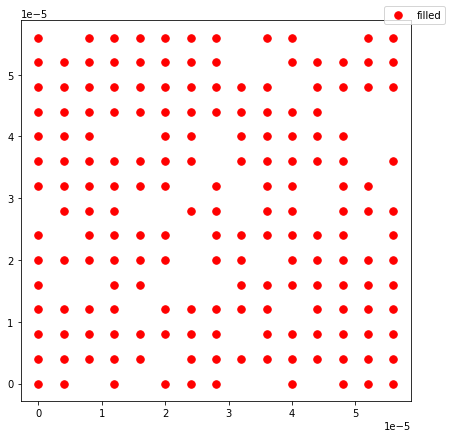

In [4]:
show_register(register)

### Driving field

1. The time points have to start from zero
2. The time points have to have certain resolution
3. The time points have to sorted ascendinly
4. The maximum duration of the program 
5. The amplitude has to start and end at 0
6. The phase has to start from 0
7. The driving fields have to have certain resolution


In [6]:
from braket.ahs.time_series import TimeSeries
from braket.ahs.driving_field import DrivingField

amplitude_min = 0          # rad / s
amplitude_max = 25000000   # rad / s

detuning_min = -125000000  # rad / s
detuning_max = 125000000   # rad / s

time_max = 4e-6  # s
time_ramp = 1e-7  # s

time_points = [0, time_ramp, time_max - time_ramp, time_max]
amplitude_values = [amplitude_min, amplitude_max, amplitude_max, amplitude_min]
detuning_values = [detuning_min, detuning_min, detuning_max, detuning_max]
phase_values = [0, 16.89, -78.1, 34.8]

amplitude = TimeSeries()
for t, v in zip(time_points, amplitude_values):
    amplitude.put(t, v)

detuning = TimeSeries()
for t, v in zip(time_points, detuning_values):
    detuning.put(t, v)

phase = TimeSeries()
for t, v in zip(time_points, phase_values):
    phase.put(t, v)

# Note: Since all attributes of QuEra Aquila's driving field are uniform,
#       we pass the TimeSeries objects directly to the constructor.
#       This will contruct braket.ahs.field.Field objects with uniform patterns for the attributes.
drive = DrivingField(
    amplitude=amplitude, 
    detuning=detuning, 
    phase=phase
)


### AHS program

We can assemble the register and Hamiltonian to an AHS program 

In [7]:
from braket.ahs.hamiltonian import Hamiltonian
from braket.ahs.analog_hamiltonian_simulation import AnalogHamiltonianSimulation

hamiltonian = Hamiltonian()
hamiltonian += drive

ahs_program = AnalogHamiltonianSimulation(
    register=register, 
    hamiltonian=hamiltonian
)

### Device

We query the Aquila QPU on the Braket service using its unique Amazon Resource Number (ARN).

In [3]:
# from braket.aws import AwsDevice

# qpu = AwsDevice("arn:aws:braket:us-east-1::device/qpu/quera/Aquila")
# print(qpu)

In [1]:
# # [Optional] We print values to the screen for inspection by a human

# import json
# json.loads(qpu.properties.paradigm.json())

In [2]:
# # [Optional] We print values and detailed description of one particular section

# section = qpu.properties.paradigm.lattice.geometry
# print(type(section))
# print(section)
# print(section.__doc__)

### Task <a class="anchor" id="task"></a>
[back to top](#TOC)

The AHS program can be submitted to the device to create a quantum task on the Braket service.

In [4]:
# # To ensure that the program complies with resolution-specific validation rules

# discretized_ahs_program = ahs_program.discretize(qpu)

In [5]:
# # [Optional] Compare original and discretized AHS programs

# for original, discretized in zip (
#     ahs_program.hamiltonian.terms[0].amplitude.time_series.times(),
#     discretized_ahs_program.hamiltonian.terms[0].amplitude.time_series.times(),
# ):
#     print(original.__repr__(), discretized.__repr__())

In [6]:
# task = qpu.run(discretized_ahs_program, shots=100)
# print(task)

In [7]:
# # [Optional] We can investigate task metadata

# task.metadata()

## 6. Result <a class="anchor" id="result"></a>
[back to top](#TOC)

The results (once the task is completed) can be downloaded directly into an object in the python session.